In [37]:
import numpy as np
import pandas as pd


class CA:

    def __init__(self, n_components=None):
        """Corresondence analysis (CA)
        Linear dimensionality reduction using Singular Value Decomposition of
        the data to project it to a lower dimensional space.

        Parameters
        ----------
        n_components : int
            Number of components to keep.
            if n_components is None all components with nonzero variance are
            kept:
                n_components = (singular values array > 1e-16).sum()

        Attributes
        ----------
        grand_total_ : int
            Total number of sample points (observations).
        row_masses_ : array, [n_row_vars]
            Sample-estimated probability distribution of row variables.
        col_masses_ : array, [n_col_vars]
            Sample-estimated probability distribution of col variables.
        corrspnd_mat_ : array, [n_row_vars, n_col_vars]
            Correspondence matrix. A sample-estimated join probability
            distribution of row and col variables.
        centr_corrspnd_mat_ : array, [n_row_vars, n_col_vars]
            Relative frequency matrix. Centered correspondence matrix with
            elements be centered at their independent joint probabilities.
        chi_squared_ : float
            Pearson's chi-squared statistics.
        pearson_resd_ : array, [n_row_vars, n_col_vars]
            Pearson residual matrix
        principal_inertias_ : array, [n_components]
            Principal inertias, variance of principal components.
        princpl_coords_row_ : array, [n_row_vars, n_components]
            Principal coordinates of row variables.
        princpl_coords_col_ : array, [n_col_vars, n_components]
            Principal coordinates of col variables.
        std_coords_row_ = array, [n_row_vars, n_components]
            Standard coordinates of row variables.
        std_coords_col_ = array, [n_col_vars, n_components]
            Standard coordinates of col variables.

        References
        ----------
        Alan J. Izenman
        Modern Multivariate Statistical Techniques:
        Regression, Classification, and Manifold Learning

        Michael Greenacre
        Correspondence Analysis in Practice, Third Edition
        Appendix A: Theory of Correspondence Analysis

        Oleg Nenadic and Michael Greenacre
        Computation of Multiple Correspondence Analysis, with code in R
        https://core.ac.uk/download/pdf/6591520.pdf

        Examples
        --------
        see https://github.com/YiChanLee/correspondence-analysis
        """
        # total number of components to be kept
        self.n_components = n_components

    def fit(self, contingency_table, pearson_resd=None, y=None):
        """Fit the model with X.
        Parameters
        ----------
        contignency_table: array-like, shape (n_row_vars, n_col_vars)
            Training data, where n_row_vars is the number of row variables
            and n_col_vars is the number of column variables.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        if type(contingency_table) is pd.DataFrame:
            contingency_table = contingency_table.values
        # total number of sample points
        grand_total = contingency_table.sum().sum()

        # probabilities of a sample belonging to row and col variables
        row_masses = contingency_table.sum(axis=1) / grand_total
        col_masses = contingency_table.sum(axis=0) / grand_total

        # joint probabilities of row and col variables
        corrspnd_mat = contingency_table / grand_total
        # expected joint probabilities of independent assumptions
        expc_freq = np.kron(row_masses.reshape(-1, 1),
                            col_masses.reshape(1, -1))
        centr_corrspnd_mat = corrspnd_mat - expc_freq

        # chi squared statistics
        chi_squared = \
            grand_total * ((centr_corrspnd_mat ** 2) / expc_freq).sum().sum()

        # inverse square root of row and col masses for later computations
        Dr_sqrt_inv = np.diag(1 / np.sqrt(row_masses))
        Dc_sqrt_inv = np.diag(1 / np.sqrt(col_masses))
        #Dc_sqrt_inv = np.diag([10] * 10)
        #Dr_sqrt_inv = np.diag([100] * 100)

        # Pearson's residuals
        if pearson_resd is None:
            pearson_resd = Dr_sqrt_inv @ centr_corrspnd_mat @ Dc_sqrt_inv
        else:
            pearson_resd = pearson_resd
    
                
        U, D_lamb, V_T = np.linalg.svd(pearson_resd, full_matrices=False)

        # pricipal inertias a.k.a. variance of variables
        principal_inertias = D_lamb ** 2

        # make 1D array of singular values into a 2D array
        D_lamb_mat = np.diag(D_lamb)

        # principal coordinates of row and col variables
        princpl_coords_row = Dr_sqrt_inv @ U @  D_lamb_mat
        princpl_coords_col = Dc_sqrt_inv @ V_T.T @ D_lamb_mat.T

        # standard coordinates of row and col variables
        std_coords_row = Dr_sqrt_inv @ U
        std_coords_col = Dc_sqrt_inv @ V_T.T

        # compute the rank of Pearson's residual matrix
        if self.n_components is None:
            self.n_components = (D_lamb > 1e-16).sum()

        # save statistics
        self.grand_total_ = grand_total
        self.row_masses_ = row_masses
        self.col_masses_ = col_masses
        self.corrspnd_mat_ = corrspnd_mat
        self.centr_corrspnd_mat_ = centr_corrspnd_mat
        self.chi_squared_ = chi_squared
        self.pearson_resd_ = pearson_resd
        self.principal_inertias_ = principal_inertias
        self.princpl_coords_row_ = princpl_coords_row[:, :self.n_components]
        self.princpl_coords_col_ = princpl_coords_col[:, :self.n_components]
        self.std_coords_row_ = std_coords_row
        self.std_coords_col_ = std_coords_col

        return self

    def get_princpl_coords_df(self, row_categories=None, col_categories=None):
        """Get the pandas.DataFrame of principal coordinates
        Parameters:
        ----------
        row_categories : array, shape (contingency_table.shape[0], )
            names of row variables

        col_categories : array, shape (contingency_table.shape[1], )
            names of col variables

        Returns:
        ----------
        (row_princpl_coords_dataframe, col_princpl_coords_dataframe) : tuple
        """
        # DataFrame index: Dim 0, Dim 1, ...
        inds = ['Dim {}'.format(i) for i in range(self.n_components)]

        row_pcs_df = pd.DataFrame(data=self.princpl_coords_row_,
                                  columns=inds,
                                  index=row_categories)
        col_pcs_df = pd.DataFrame(data=self.princpl_coords_col_,
                                  columns=inds,
                                  index=col_categories)
        return row_pcs_df, col_pcs_df

    def get_std_coords_df(self, row_categories=None, col_categories=None):
        """Get the pandas.DataFrame of standard coordinates
        Parameters:
        ----------
        row_categories : array, shape (contingency_table.shape[0], )
            names of row variables

        col_categories : array, shape (contingency_table.shape[1], )
            names of col variables

        Returns:
        ----------
        (row_standard_coords_dataframe, col_standard_coords_dataframe) : tuple
        """
        # DataFrame index: Dim 0, Dim 1, ...
        inds_row = \
            ['Dim {}'.format(i) for i in range(self.corrspnd_mat_.shape[0])]
        inds_col = \
            ['Dim {}'.format(i) for i in range(self.corrspnd_mat_.shape[1])]

        row_stds_df = pd.DataFrame(data=self.std_coords_row_,
                                   columns=inds_row,
                                   index=row_categories)
        col_stds_df = pd.DataFrame(data=self.std_coords_col_,
                                   columns=inds_col,
                                   index=col_categories)
        return row_stds_df, col_stds_df

    def transform(self, supp_points, row=True):
        if row:
            row_masses = supp_points.sum(axis=1)
            row_masses_inv = np.diag(1 / row_masses)
            return row_masses_inv @ supp_points @ self.std_coords_col_
        else:
            col_masses = supp_points.sum(axis=0)
            col_masses_inv = np.diag(1 / col_masses)
            return col_masses_inv @ supp_points.T @ self.std_coords_row_


In [38]:
import numpy as np
import matplotlib.pyplot as plt

ncells = 1000  # Number of cells
ngenes = 100
ncategories = 10  # liczba kategorii dla każdego genu



#np.random.shuffle(arr)
xmus = [0, 5, 5, 8]
xsds = [1, 0.1, 1, 1]
ymus = [5, 5, 0, 8]
ysds = [1, 0.1, 1, 1]

prop1 = [0.3, 0.5, 0.2, 0]
comp1 = np.random.choice([1, 2, 3, 4], p=prop1, size=ncells, replace=True)


proj = np.random.normal(size=(ngenes, 2))


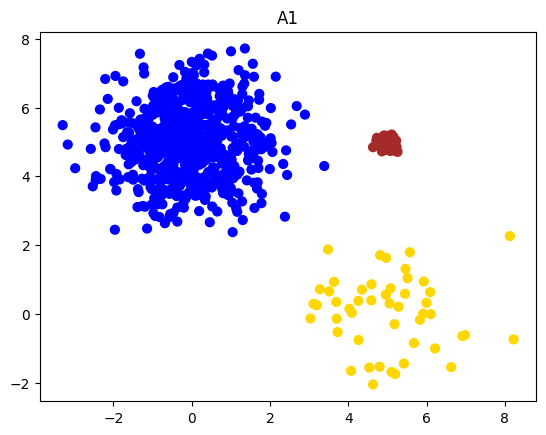

In [44]:
easy_values = [False, True]

prop2 = [0.65, 0.3, 0.05]

# Setting proportions of each of the three cell types in batch 2.
comp2 = np.random.choice([1, 2, 3], p=prop2, size=ncells, replace=True)
samples2 = np.column_stack((np.random.normal(loc=np.array(xmus)[comp2-1], scale=np.array(xsds)[comp2-1], size=ncells),
                            np.random.normal(loc=np.array(ymus)[comp2-1], scale=np.array(ysds)[comp2-1], size=ncells)))
ref_cols = ["blue", "brown", "gold"]
clust1 = [ref_cols[i-1] for i in comp2]

plt.scatter(samples2[:, 0], samples2[:, 1], marker='o', s=40, c=clust1)

plt.title('A1')
plt.show()

person_r_random = np.dot(samples2, proj.T)

#A2 = np.transpose(A2)
row_names = [f"Cell{i+1}-1" for i in range(ncells)]
col_names = [f"Gene{i+1}" for i in range(ngenes)]


In [47]:
import numpy as np

# Generowanie danych z rozkładu Poissona
lambda_value = 5.0  # wartość średnia dla rozkładu Poissona
contingency_table = np.random.poisson(lambda_value, size=(ncells, ngenes))

print("Przykładowe dane z rozkładu Poissona:")
print(contingency_table.shape)


Przykładowe dane z rozkładu Poissona:
(1000, 100)


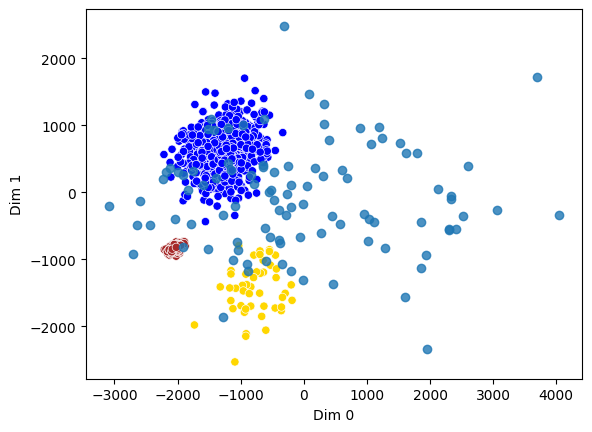

In [50]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


transfer = CA()


transfer.fit(contingency_table=contingency_table, pearson_resd=person_r_random)

pcs_row, pcs_col = \
    transfer.get_princpl_coords_df(row_categories=row_names,
                                   col_categories=col_names)
pcs_row['Dim 1'] = pcs_row['Dim 1']
pcs_col['Dim 1'] = pcs_col['Dim 1']

variances = transfer.principal_inertias_
percent_explnd_var = (variances / variances.sum()) * 100

fig, ax = plt.subplots()
sns.scatterplot(x='Dim 0', y='Dim 1', data=pcs_row, color = clust1, ax=ax)
sns.regplot(x='Dim 0', y='Dim 1', data=pcs_col, fit_reg=False, ax=ax)
#for i, txt in enumerate(list(row_names)):
#    ax.annotate(txt, (pcs_row.iloc[i]['Dim 0'], pcs_row.iloc[i]['Dim 1']))
#for i, txt in enumerate(list(col_names)):
#    ax.annotate(txt, (pcs_col.iloc[i]['Dim 0'], pcs_col.iloc[i]['Dim 1']))


ax.set_xlabel('Dim 0')
ax.set_ylabel('Dim 1')
plt.show()



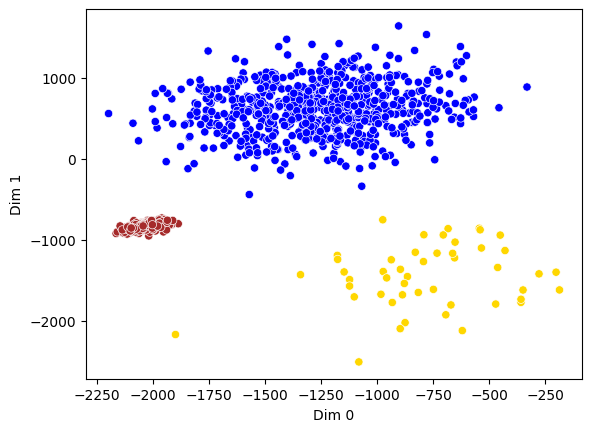

In [46]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


transfer = CA()


transfer.fit(contingency_table=contingency_table, pearson_resd=person_r_random)

pcs_row, pcs_col = \
    transfer.get_princpl_coords_df(row_categories=row_names,
                                   col_categories=col_names)
pcs_row['Dim 1'] = pcs_row['Dim 1']
pcs_col['Dim 1'] = pcs_col['Dim 1']

variances = transfer.principal_inertias_
percent_explnd_var = (variances / variances.sum()) * 100

fig, ax = plt.subplots()
sns.scatterplot(x='Dim 0', y='Dim 1', data=pcs_row, color = clust1, ax=ax)
#sns.regplot(x='Dim 0', y='Dim 1', data=pcs_col, fit_reg=False, ax=ax)
#for i, txt in enumerate(list(row_names)):
#    ax.annotate(txt, (pcs_row.iloc[i]['Dim 0'], pcs_row.iloc[i]['Dim 1']))
#for i, txt in enumerate(list(col_names)):
#    ax.annotate(txt, (pcs_col.iloc[i]['Dim 0'], pcs_col.iloc[i]['Dim 1']))


ax.set_xlabel('Dim 0')
ax.set_ylabel('Dim 1')
plt.show()

